In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import Counter
import os
import cv2  # For image processing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load JSON data
photo_data = pd.read_json('photos.json', lines=True)

In [3]:
# Set target sample size
target_size = 1678
sampled_data = photo_data.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=target_size, replace=True, random_state=42)
    if len(x) < target_size else x.sample(n=target_size, random_state=42)
).sample(frac=1, random_state=42).reset_index(drop=True)


C:\Users\jini\AppData\Local\Temp\ipykernel_23348\3605846441.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = photo_data.groupby('label', group_keys=False).apply(


In [5]:
# Function to load and preprocess images
def load_and_preprocess_images(sampled_data, img_size=(224, 224)):
    images = []
    labels = []
    for _, row in sampled_data.iterrows():
        img_path = os.path.join('photos', f"{row['photo_id']}.jpg")
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            
            # Apply Gaussian Blur and Histogram Equalization
            img_array = cv2.GaussianBlur(img_array, (5, 5), 0)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
            img_array = cv2.equalizeHist((img_array * 255).astype(np.uint8))  # Histogram equalization
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)  # Convert back to RGB

            images.append(img_array)
            labels.append(row['label'])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

In [6]:
# Load and preprocess images
images_array, labels_array = load_and_preprocess_images(sampled_data)

Error loading image photos\ki0z-58NcxLiwB2lFerEMA.jpg: [Errno 2] No such file or directory: 'photos\\ki0z-58NcxLiwB2lFerEMA.jpg'
Error loading image photos\vejqfjsReeC16GzSeUIjBg.jpg: [Errno 2] No such file or directory: 'photos\\vejqfjsReeC16GzSeUIjBg.jpg'
Error loading image photos\c2xMnCb40P4szjnHQW7RHg.jpg: [Errno 2] No such file or directory: 'photos\\c2xMnCb40P4szjnHQW7RHg.jpg'
Error loading image photos\YQP1MseLyRjPOQ66pdi2uw.jpg: [Errno 2] No such file or directory: 'photos\\YQP1MseLyRjPOQ66pdi2uw.jpg'
Error loading image photos\JGL06eKEL5cYETc3wis1Eg.jpg: [Errno 2] No such file or directory: 'photos\\JGL06eKEL5cYETc3wis1Eg.jpg'
Error loading image photos\Y38EybhxeX-PHVHPKieMdQ.jpg: [Errno 2] No such file or directory: 'photos\\Y38EybhxeX-PHVHPKieMdQ.jpg'
Error loading image photos\qXedooX3y7RVx5ufaloyfQ.jpg: [Errno 2] No such file or directory: 'photos\\qXedooX3y7RVx5ufaloyfQ.jpg'
Error loading image photos\H8L9pWB_fGsSwg7AE5Vq4Q.jpg: [Errno 2] No such file or directory: 'phot

In [7]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_array)
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels)

In [8]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(images_array, one_hot_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [9]:
# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [10]:
# Load EfficientNetB0 with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [11]:
# Unfreeze some layers in EfficientNetB0 for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True

In [12]:
# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    BatchNormalization(),
    Dense(one_hot_labels.shape[1], activation='softmax')
])


c:\Users\jini\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
# Compile model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
# Train the model using the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping]
)


c:\Users\jini\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.2382 - loss: 2.1896 - val_accuracy: 0.4394 - val_loss: 1.3966
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.3786 - loss: 1.6664 - val_accuracy: 0.5909 - val_loss: 1.0945
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.4334 - loss: 1.5234 - val_accuracy: 0.6818 - val_loss: 0.9216
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - accuracy: 0.5767 - loss: 1.1407 - val_accuracy: 0.7045 - val_loss: 0.8156
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 173s 5s/step - accuracy: 0.5863 - loss: 1.0936 - val_accuracy: 0.7197 - val_loss: 0.7309
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.6161 - loss: 1.0079 - val_accuracy: 0.7424 - val_loss: 0.6675
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.6695 - loss: 0.9423 - val_accuracy: 0.7576 - val_loss: 0.6200
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.6539 - loss: 0.9323 - val_accuracy: 0.7576 - v

In [15]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 0.9021 - loss: 0.3564
Test Loss: 0.37529146671295166
Test Accuracy: 0.8939393758773804


In [16]:
# Generate predictions and plot confusion matrix
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


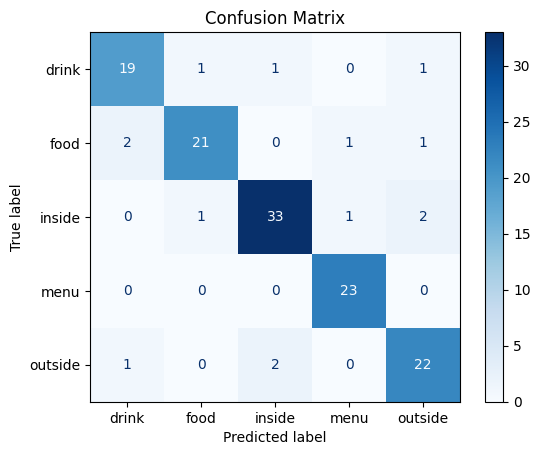

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

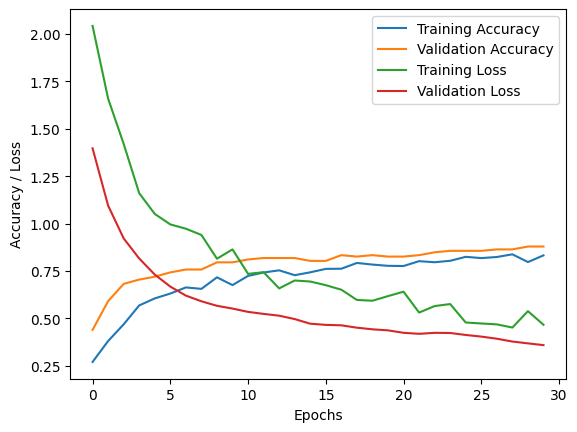

In [18]:
# Plot training history
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

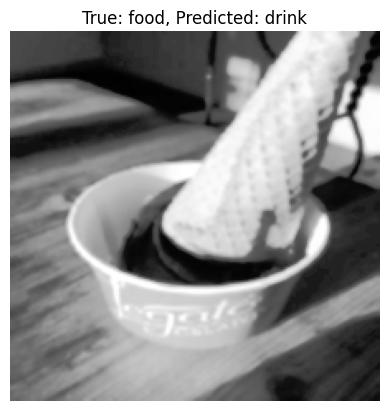

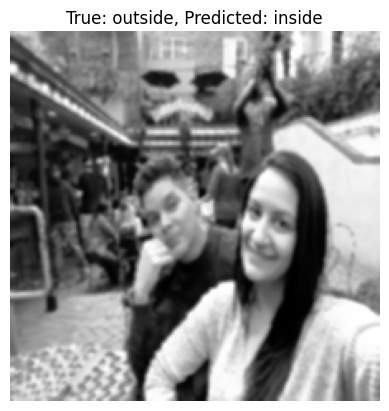

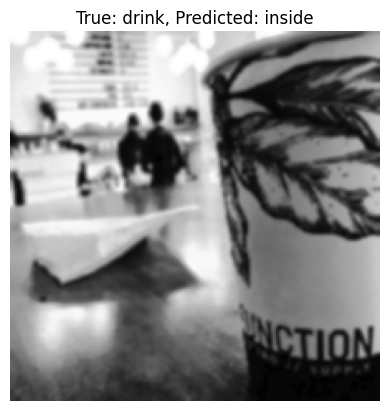

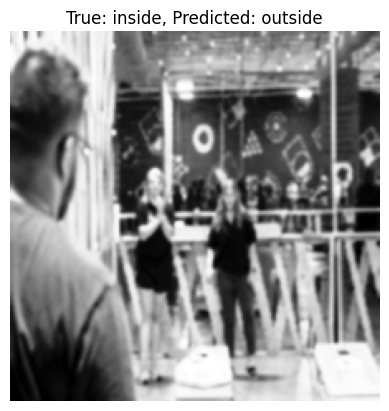

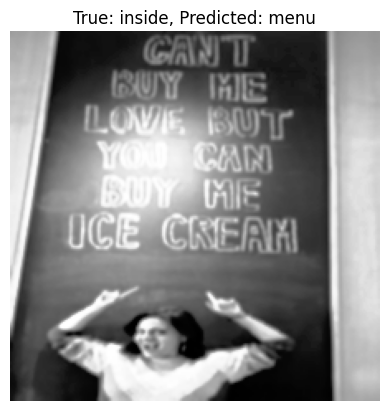

In [19]:
# Display a few misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]
for idx in misclassified_indices[:5]: 
    img = X_test[idx]
    true_label = label_encoder.inverse_transform([true_classes[idx]])[0]
    pred_label = label_encoder.inverse_transform([predicted_classes[idx]])[0]
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis('off')
    plt.show()